In [1]:
import numpy as np
import scipy.sparse as sp

In [54]:
def mean_average_precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.isin(recommendations, relevant_items, assume_unique=True)
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score


def evaluator(recommender: object, urm_test:sp.csr_matrix, cutoff = 10):
    recommendation_length = cutoff
    accum_precision = 0
    accum_recall = 0
    accum_map = 0
    urm_train = recommender.get_URM_train()
    num_users = urm_train.shape[0]
    interactions_per_user = np.diff(urm_train.indptr)
    user_map = []
    user_ids = []
    user_inter = []
    num_users_evaluated = 0
    num_users_skipped = 0
    for user_id in range(num_users):
        user_profile_start = urm_test.indptr[user_id]
        user_profile_end = urm_test.indptr[user_id + 1]

        relevant_items = urm_test.indices[user_profile_start:user_profile_end]

        if relevant_items.size == 0:
            num_users_skipped += 1
            continue

        recommendations = recommender.recommend(user_id_array=user_id,
                                                cutoff=recommendation_length)

        MAP = mean_average_precision(recommendations, relevant_items)
        
        num_users_evaluated += 1
        
        user_ids.append(user_id)
        user_map.append(MAP)
        user_inter.append(interactions_per_user[user_id])
    user_map = np.array(user_map)
    user_ids = np.array(user_ids, dtype=np.int32)
    user_inter = np.array(user_inter, dtype=np.int32)    
    return user_ids, user_map, user_inter


In [108]:
def interval_map(user_map, step = 10):
    result = {}
    for start in range(0, max(user_map[2]),step):
        end = min(start+step, max(user_map[2]))
        map_sum = 0
        inter_count = 0
        counter = 0
        for inter in user_map[2]:
            if inter <= end and inter > start:
                map_sum += user_map[1][counter]
                inter_count += 1
            counter += 1
        if map_sum == 0:
            continue
        map_sum /= inter_count
        interval = str(start) + '-' + str(end)
        result[interval]=map_sum
    return result

In [106]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
def plot_dic(result):
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(range(len(result)), list(result.values()), align='center')
    plt.xticks(range(len(result)), list(result.keys()))

In [93]:
def normalize_dict(result):
    result_norm = result.copy()
    sum_map = sum(result_norm.values())
    for item in result_norm.items():
        result_norm[item[0]]/=sum_map
    sum(result_norm.values())
    return result_norm
    

In [14]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from DataParser import DataParser
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

parser = DataParser()
URM_all = parser.get_URM_all()
ICM = parser.get_icm()
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85, seed=1024)
SlimBPR = SLIM_BPR_Cython(URM_train)
SlimBPR.fit(topK= 860, epochs= 190, symmetric= False, sgd_mode= 'adam', lambda_i= 0.01, lambda_j= 1e-05, learning_rate= 0.0001)
user_map = evaluator(SlimBPR, URM_test)

SLIM_BPR_Recommender: URM Detected 42 (0.53 %) cold users.
SLIM_BPR_Recommender: URM Detected 1971 (7.59 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 7.47E-07. Sample per second: 16487
SLIM_BPR_Recommender: Epoch 1 of 190. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 5.24E-06. Sample per second: 14615
SLIM_BPR_Recommender: Epoch 2 of 190. Elapsed time 0.13 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 7.84E-06. Sample per second: 13363
SLIM_BPR_Recommender: Epoch 3 of 190. Elapsed time 0.18 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 1.27E-05. Sample per second: 12404
SLIM_BPR_Recommender: Epoch 4 of 190. Elapsed time 0.22 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 

Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 9.23E-04. Sample per second: 15856
SLIM_BPR_Recommender: Epoch 52 of 190. Elapsed time 1.08 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 9.27E-04. Sample per second: 15487
SLIM_BPR_Recommender: Epoch 53 of 190. Elapsed time 1.09 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 9.85E-04. Sample per second: 15133
SLIM_BPR_Recommender: Epoch 54 of 190. Elapsed time 1.11 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 1.08E-03. Sample per second: 14821
SLIM_BPR_Recommender: Epoch 55 of 190. Elapsed time 1.12 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 9.86E-04. Sample per second: 14523
SLIM_BPR_Recommender: Epoch 56 of 190. Elapsed time 1.13 sec
Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 1.13E-03. Sample per second: 14213
SLIM_BPR_Recommender: Epoch 57 of 190. Elapsed time 1.14 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 1.09E-03. Sample per second: 139

Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 2.46E-03. Sample per second: 144609
SLIM_BPR_Recommender: Epoch 106 of 190. Elapsed time 1.64 sec
Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 2.52E-03. Sample per second: 122358
SLIM_BPR_Recommender: Epoch 107 of 190. Elapsed time 1.65 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 2.51E-03. Sample per second: 107465
SLIM_BPR_Recommender: Epoch 108 of 190. Elapsed time 1.66 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 2.56E-03. Sample per second: 94667
SLIM_BPR_Recommender: Epoch 109 of 190. Elapsed time 1.67 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 2.63E-03. Sample per second: 84590
SLIM_BPR_Recommender: Epoch 110 of 190. Elapsed time 1.68 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 2.54E-03. Sample per second: 76454
SLIM_BPR_Recommender: Epoch 111 of 190. Elapsed time 1.69 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.73E-03. Sample per se

Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 4.26E-03. Sample per second: 13800
SLIM_BPR_Recommender: Epoch 159 of 190. Elapsed time 2.16 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 4.28E-03. Sample per second: 13564
SLIM_BPR_Recommender: Epoch 160 of 190. Elapsed time 2.17 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 4.21E-03. Sample per second: 13336
SLIM_BPR_Recommender: Epoch 161 of 190. Elapsed time 2.18 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 4.43E-03. Sample per second: 13138
SLIM_BPR_Recommender: Epoch 162 of 190. Elapsed time 2.19 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 4.43E-03. Sample per second: 12903
SLIM_BPR_Recommender: Epoch 163 of 190. Elapsed time 2.20 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 4.44E-03. Sample per second: 12697
SLIM_BPR_Recommender: Epoch 164 of 190. Elapsed time 2.21 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 4.37E-03. Sample per secon

In [112]:
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.fit(topK=120, l1_ratio=1e-5, alpha=0.066)
user_map = evaluator(recommender_slim, URM_test)

SLIMElasticNetRecommender: URM Detected 42 (0.53 %) cold users.
SLIMElasticNetRecommender: URM Detected 1971 (7.59 %) cold items.
SLIMElasticNetRecommender: Processed 9133 ( 35.16% ) in 5.00 min. Items per second: 30.42
SLIMElasticNetRecommender: Processed 19788 ( 76.18% ) in 10.00 min. Items per second: 32.96
SLIMElasticNetRecommender: Processed 25975 ( 100.00% ) in 12.88 min. Items per second: 33.61


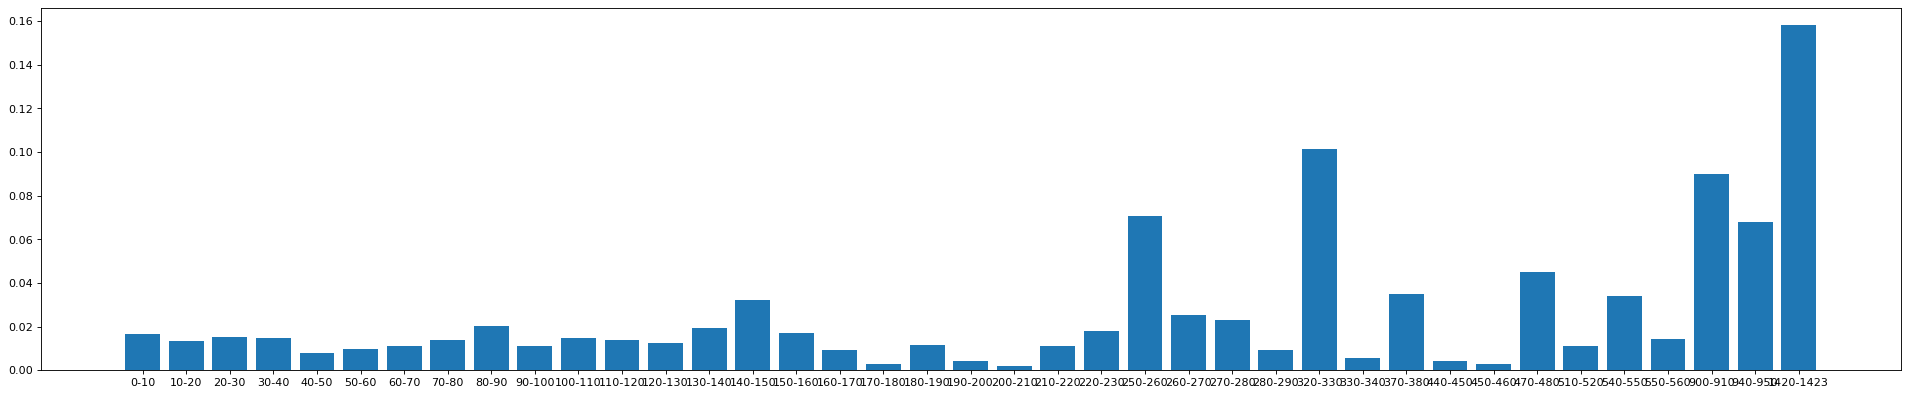

In [113]:
result = interval_map(user_map, step = 10)
result = normalize_dict(result)
plot_dic(result)